<a href="https://colab.research.google.com/github/xin-2001/taica_1132_GenAI/blob/main/HW3/113_2GenAI_HW3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業三-1
1. 找一個GAN模型來實際操作，並且試著多生幾張圖片。(上課沒說過的也可以)

  繳交方式：
  - 寫明是主題幾。
  - 附上該模型來源(連結)，並簡單介紹這個模型。
  - 同主題多生成幾張，並且附上輸入/輸出圖。(最多五組)
  - 比較看看，為什麼現在較沒有人在使用GAN來生圖？
  - 可以自行增加其他內容。

  (為了助教們批改作業時閱讀順利，請將同一組輸入/輸出合併在一起為一張圖片)


---- 以下主題請以 Colab + 截圖的方式繳交，也可以繳交pdf檔。----

2. 研究GAN背後原理，試著用自己的方式解釋Cross Entropy、KL divergence。
  (延伸內容：實際計算、比較兩者的效果、程式實驗、使用情境等等)

  繳交方式：
  - 寫明是主題幾。
  - colab連結(請記得將共用權限打開)or附上pdf檔。
  - 請在重點處以 MarkDown 註明，並且貼上重點截圖。
  - 也可以自行增加內容。

## 基本套件

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 中文字體
- 內建為包含中文字體，因此在圖表中若需加入中文字體，如：標題、圖例等，需先載入中文字體。

In [ ]:
!apt-get install -y wget
!wget -O LXGWWenKaiMonoTC-Regular.ttf "https://github.com/lxgw/LxgwWenkaiTC/raw/main/fonts/TTF/LXGWWenKaiMonoTC-Regular.ttf"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
--2025-02-19 16:07:42--  https://github.com/lxgw/LxgwWenkaiTC/raw/main/fonts/TTF/LXGWWenKaiMonoTC-Regular.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lxgw/LxgwWenkaiTC/main/fonts/TTF/LXGWWenKaiMonoTC-Regular.ttf [following]
--2025-02-19 16:07:42--  https://raw.githubusercontent.com/lxgw/LxgwWenkaiTC/main/fonts/TTF/LXGWWenKaiMonoTC-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response...

In [ ]:
import matplotlib.font_manager as fm
# 設定中文字體
font_path = '/content/LXGWWenKaiMonoTC-Regular.ttf'  # 替換為您的字體檔案路徑
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
plt.rcParams['axes.unicode_minus'] = False

## 主題一：GAN模型生圖

### Gemini生成程式碼


好的，我可以教你如何使用 GAN 生成圖像。以下是用 GAN 生成圖像的程式碼範例，並附上步驟說明：

- 使用 GAN 生成圖像
這個範例使用 MNIST 資料集訓練一個簡單的 GAN 模型，並生成手寫數字圖像。

1. 步驟 1：導入必要的庫
```python
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
Use code with caution
```
2. 步驟 2：定義生成器模型
```python
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
```
3. 步驟 3：定義判別器模型
```python
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
```
4. 步驟 4：定義損失函數和優化器
```python
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
```
5. 步驟 5：定義訓練循環
```python
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
```
6. 步驟 6：訓練模型
```python
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)
```
7. 步驟 7：生成圖像
```python
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
```
8. 完整程式碼
```python
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
#定義生成器、判別器、損失函數、優化器等
#載入 MNIST 資料集
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#創建模型
generator = make_generator_model()
discriminator = make_discriminator_model()
#訓練模型
train(train_dataset, EPOCHS)
```

- 注意事項：

這個程式碼範例僅供參考，您可以根據您的需求修改模型架構、超參數等。
GAN 的訓練過程可能比較不穩定，需要仔細調整超參數。
希望以上資訊對您有所幫助。


### 主程式

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [3]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [5]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [6]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

  # Generate after the final epoch
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [7]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


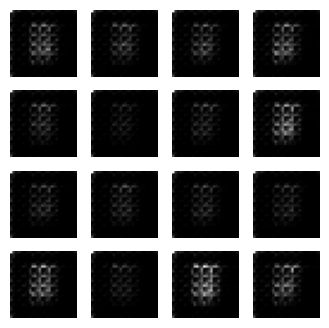

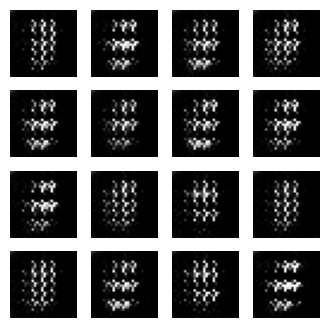

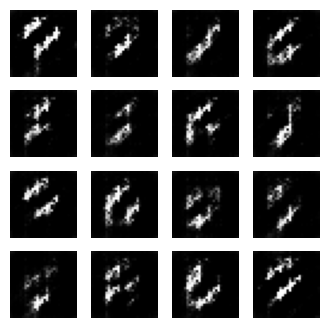

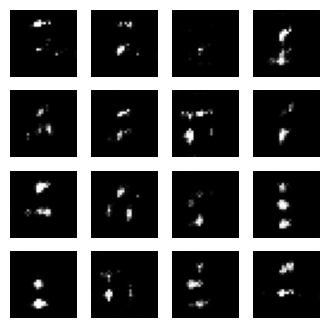

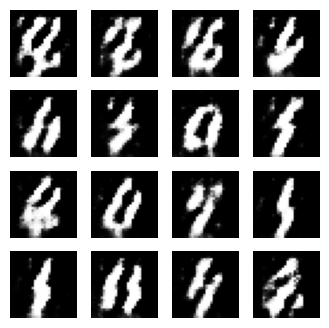

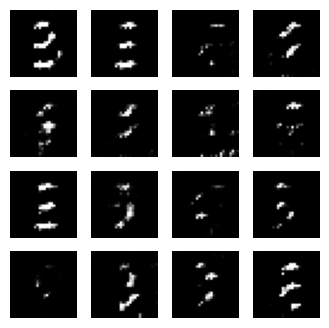

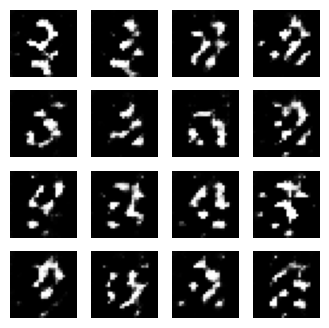

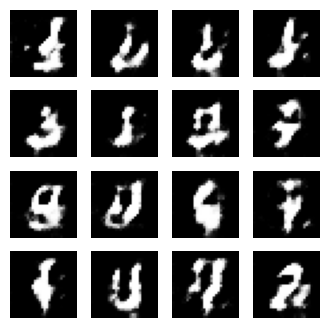

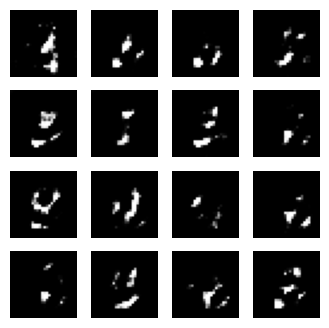

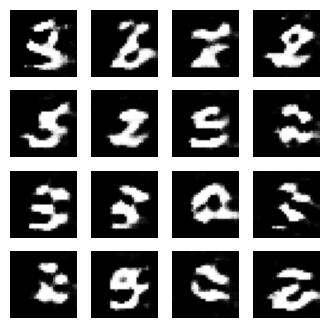

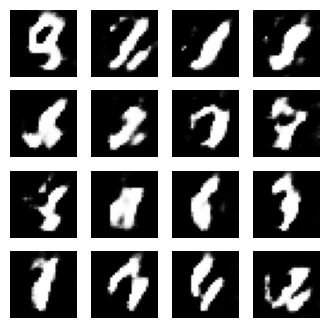

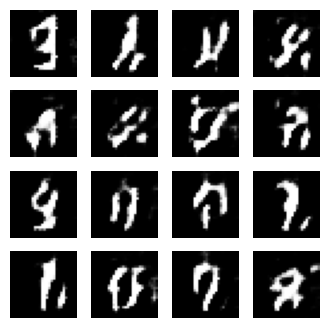

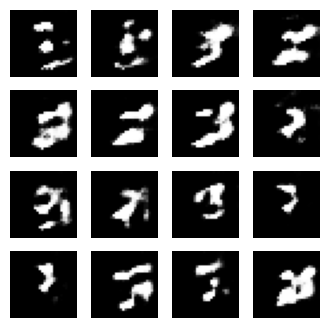

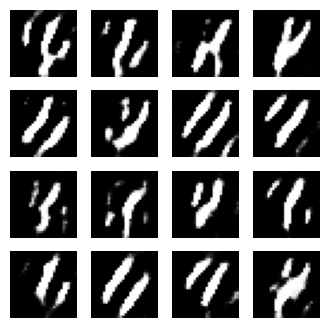

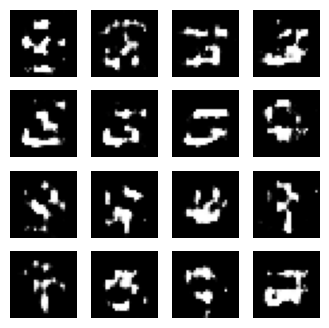

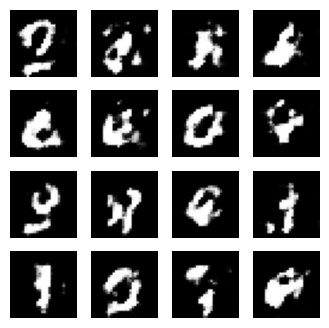

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# 定義生成器、判別器、損失函數、優化器等

# 載入 MNIST 資料集
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 創建模型
generator = make_generator_model()
discriminator = make_discriminator_model()

# 訓練模型
train(train_dataset, EPOCHS)

### 成果展現
-
-
  

## 評分標準：

1. 主題一：

  - 6分：1-2組圖片(輸入/輸出 合併起來為1組)。
  - 7分：3-5組圖片。
  - 8分：完成說明4、5點。

  有附上該模型來源(連結)，並清楚介紹這個模型 + 2分

---

2. 主題二：

  - 0分：作答區中無附檔或無Colab連結(不論是否有附圖)。
  - 0分：程式連結無法順利開啟，且無截圖。
  - 2分：GPT 水準或繳交作業與本周主題無關(若貼成別週作業也列在此。)
  - 3分：程式連結無法順利開啟，但有部份截圖。
  - 8分：(colab)只有一連串程式，沒有MarkDown來說明。(pdf)只有文字，沒有重點標示
  - 10分：(colab)有漂亮的MarkDown來說明。(pdf)是份完美的報告。

  >- 註一：若沒有引入老師的固定4行套件，總分 -1。
  >- 註二：程式連結無法順利開啟包含 1.權限未開啟 2.繳交非colab連結的檔案 3.程式碼無法完整執行
  >- 註三：有請生成式AI幫忙的地方請特別說明，加上理解後的說明，並附上截圖(包括Prompt與生成結果)，不然都當抄襲AI。
  >- 註四：若認定抄襲，除該次作業0分外，總成績-10，再犯再扣，直至總成績扣完為止。